# VMTutorial Example

## Random Relax

In this example, we load a configuration of $N=1000$ cells placed at random in a periodic square box of size $60\times60$.

We will use the standard vertex model with energy given as $$E = \frac{1}{2}\sum_c\left[\kappa(A_c - A_0)^2 + \Gamma P_c^2 - \Lambda P_c\right],$$where $\kappa$ is the area modulus, $\Gamma$ is the perimeter modulus, and $\Lambda = 2\Gamma P_0$.

The equation of motion for vertex $i$ is $$\gamma\dot{\mathbf{r}}_i = -\nabla_{\mathbf{r}_i}E,$$where $\gamma$ is the friction coefficient between the vertex and the substrate.

### Loading the VM simulation module

In [1]:
from VMToolkit.VM import *

### Parameters

Model parameters

In [2]:
kappa = 1.0
Gamma = 0.25
Lambda = 1.7
gamma = 1.0

Simulation parameters

In [3]:
input_file = 'random_conf.json'
dt = 0.1
rng_seed = 1892
dumpfreq = 10
nrun = 100
timeunit = int(round(1/dt))

### Simulation initialisation

We now set the simulation object that will constrol the execution.

In [4]:
tissue  = Tissue()                                               # initialise mesh
sim_sys = System(tissue)                                         # base object for the system
forces = Force(sim_sys)                                          # handles all types of forces
integrators = Integrate(sim_sys, forces, rng_seed)               # handles all integrators
topology = Topology(sim_sys, forces)                             # handles all topology changes (T1, division, ingression)
dumps = Dump(sim_sys, forces)                                    # handles all data output 
simulation = Simulation(sim_sys, integrators, forces, topology)  # simulation object

We proceed to read in the data.

In [5]:
sim_sys.read_input(input_file)

Setting periodic simulation box.
Finished reading vertices.
Finished reading faces.
Finished mesh setup.
Mesh has 2000 vertices 3000 edges and 1000 faces.
Finished reading input configuration.


We now plot it to see how it looks like.

In [6]:
from tissue_plot import make_plotter
make_plotter(tissue).show()

Widget(value="<iframe src='http://localhost:40297/index.html?ui=P_0x7fc62879f460_0&reconnect=auto' style='widt…

### Add model (force) and assign parameter values

In [7]:
forces.add('area')         # add area force form term E = 0.5*kappa*(A-A0)^2
forces.add('perimeter')    # add perimeter force term from E = 0.5*gamma*P^2 - lambda*P 

Assign parameters to cell type 'passive'

In [8]:
forces.set_params('area', 'passive', {'kappa' : kappa})
forces.set_params('perimeter', 'passive',  {'gamma': Gamma, 'lambda': Lambda})

### Set topology change (i.e. T1 transition) conditions

In [9]:
topology.set_params({'min_edge_len': 0.05, 'new_edge_len': 0.055}) 

### Add integrator for the equations of motion (Brownian dynamics)

In [10]:
integrators.add('brownian') 

and set its timestep

In [11]:
integrators.set_dt(dt)

### Exectute simulation

We also produce output as vtp and json files for detailed visualisation and analysis.

In [19]:
for i in range(nrun):
    if i % dumpfreq == 0:
        dumps.dump_cells(f'cells_{i:08d}.vtp', draw_periodic=True)
        dumps.dump_mesh(f'mesh_{i:08d}.json')
    simulation.run(timeunit)

[========================================] 100%  --> Completed 10 simulation steps 
[========================================] 100%  --> Completed 20 simulation steps 
[========================================] 100%  --> Completed 30 simulation steps 
[========================================] 100%  --> Completed 40 simulation steps ] 80%
[========================================] 100%  --> Completed 50 simulation steps 
[========================================] 100%  --> Completed 60 simulation steps 
[========================================] 100%  --> Completed 70 simulation steps 
[========================================] 100%  --> Completed 80 simulation steps 
[========================================] 100%  --> Completed 90 simulation steps 
[========================================] 100%  --> Completed 100 simulation steps 
[========================================] 100%  --> Completed 110 simulation steps 
[====================================>   ] 90%==================] 100

### Visualisation post relaxation

We can now take a look into the relaxed configuration

In [20]:
make_plotter(tissue).show()

Widget(value="<iframe src='http://localhost:40297/index.html?ui=P_0x7fc5ca1ded90_2&reconnect=auto' style='widt…

## Basic analysis

Let's first check the energy.

In [21]:
print(f'Energy per vertex {forces.energy()/len(tissue.vertices())}')

Energy per vertex 0.025945367409384943


Then we save the final configuration to 'final.json'

In [22]:
dumps.dump_mesh('final.json')

We now import VMAnalysis module and plot the histogram of cell areas.

In [23]:
from VMToolkit.VMAnalysis import *
import numpy as np
import matplotlib.pyplot as plt

We read in the final configuration from the JSON file.

In [24]:
m = utils.HalfEdge.Mesh()
m.read_json('final.json')

Compute and collect all cell areas.

In [25]:
areas = []
for f in m.faces:
    areas.append(f.area())
areas = np.array(areas)

Plot a histogram

(array([  0.,   1.,   1.,  23., 182., 659., 132.,   2.,   0.]),
 array([3.        , 3.11111111, 3.22222222, 3.33333333, 3.44444444,
        3.55555556, 3.66666667, 3.77777778, 3.88888889, 4.        ]),
 <a list of 9 Patch objects>)

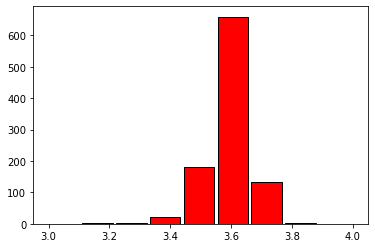

In [26]:
plt.hist(areas, bins=np.linspace(3,4,10),width=0.1,edgecolor='k', facecolor='red')